#  Monte Carlo Markov Chain

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import stats
import matplotlib.pyplot as plt
import emcee
import corner

Il metodo del Markov Chain Monte Carlo (MCMC) permette di campionare in maniera efficiente  spazi delle fasi multidimensionali.

Come abbiamo visto i metodi Monte Carlo permettono di stimare le proprietà di una distribuzione a partire da campioni casuali estratti dalla distribuzione stessa.


Le Markov Chain sono sequenze di numeri random $(X_0, X_1, ... , X_n$), in cui il valore $X_{i+1}$ dipende solamente dal valore $X_i$. 

Il metodo MCMC risulta particolarmnte utile nei casi in cui si usa l'inferenza Bayesiana  che collega una `posterior pobrability distribution`, legata alla rispondenza coi dati,  e una `prior probability distribution` che raccoglie le informazioni pregresse. In partica la coniscenza a priori su un set di parametri  viene aggiornata generarando  una distribuzioni a posteriori che include come nuova informazione la rispondenza coi dati. 


## Alogoritmi Metropolis-Hastings

La classe di algoritmi chiamata Metropolis-Hastings, data una distribuzione da campionare $h$ (ad esempio la verosimiglianza di un modello dato un set di dati) determina il passaggio per il campionamento $X_{i+1}$ a partire dall aposizione di $X_i$ nel seguente modo:

* si estrae un valore (o un vettore in uno spazio delle fasi in  più dimensioni) causale $\delta$ secondo una distribuzione predeterminata (ad esempio una gaussiana con media in zero);
* si propone uno spostamento da $X_i$ ad $X_{i+1} = X_i + \delta$;
* se $h(X_{i+1} \ge h(X_i))$ si accetta lo spostamento proposto;
* se $h(X_{i+1} < h(X_i))$ si accetta lo spostamento proposto con la probabilità pari a $r = \frac{h(X_{i+1}))}{h(X_{i}))}$ (estraendo un numero random nell'intervallo $[0,1]$ e accettand la proposta se questo à minore di $r$);
* nel caso in cui la proposta venga rifiutata $h(X_{i+1} = h(X_i))$.

## Modulo emcee

`emcee` è un modulo python che implemnta diverse funzionalità per il campionamento MCMC. Come base per definire le transizioni di una catena viene usato l'algoritmo chiamto `strech`, un evoluzione del metodo Metropolis-Hastings che utilizza più random walker contemporanemante e, per ogni walker, la proposta di un passo si basa sulla posizione di uno degli altri walker estratto casualmente. 

### Probabilità logaritmica 

Generalmente nelle applicazioni computazionali in cui si calcola il valore della verosimiglianza  si utilizza il logaritmo naturale della probabiltà che trasformando i prodotti in somme rende il calcolo computazionalmente più stabile ed evita errori di precisione numerica per valori molto bassi della probabilità.

L'intervallo delle pobabiltà logaritmiche va da $log(p) = -\inf$ per  $p=0$ a $log(p)=0$ per $p=1$.

### Esempio caduta libera (pianeta non noto)

Come esempio vediamo l'accelerazione di un grave su un pianeta non noto. 

Iniziamo definendo il modello atteso per i nostri dati assumendo di fate misure della distanza percorsa in funzione del tempo:

$$
s(t) = \frac{1}{2} a t^2
$$

In [3]:
# modello teorico 
def model_acc(params, t):
    v0, g = params
    return v0*t + 0.5*g*t**2

In [157]:
v0 = 0.7
g = 3.781 

vtruth= (v0, g)

# tempi 
time = np.arange(0.1, 1.6, 0.1)

#plt.plot(time, model_acc(vtruth, time))
#plt.show()

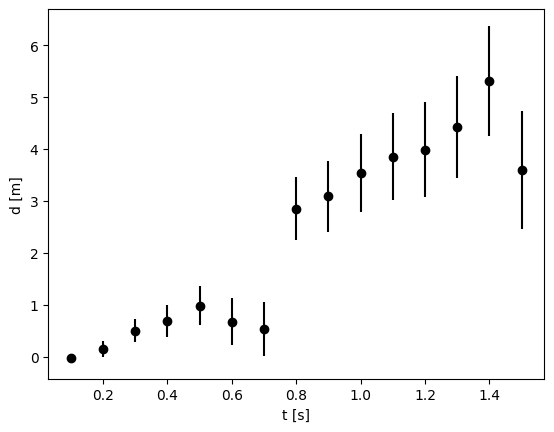

In [170]:
# dati con errori
sigmay = 0.2*g*time
accdata =  model_acc(vtruth, time) + np.random.normal(0, sigmay, len(time))

# Grafico valori misurati
plt.errorbar(time, accdata, yerr=sigmay, fmt='ok')
plt.xlabel('t [s]')
plt.ylabel('d [m]')
plt.show()

In [159]:
# logaritmo della funzione di verosimiglianza (log likelihood)
def lnlike_acc(p, t, y, yerr):
    return -0.5 * np.sum(((y - model_acc(p, t))/yerr) ** 2)

In [160]:
# logaritmo della distribuzione di probabilità  a priori (prior) per i paramtri liberi.
# non avendo infrmazioni prendiamo una distribuzione uniforme in un intervallo di valori accettabili
# log(1) = 0
# log(0) = -infinito
def lnprior_acc(p):
    v0, g = p
    if ( 0 < v0 < 10 and  0 < g < 10 ):
        return 0.0
    return -np.inf


# logaritmo della distribuzione di probabilità totale 
# log(prob) = log(prior) + log(likelihood)
def lnprob_acc(p, t, y, yerr):
    lp = lnprior_acc(p)
    
    if np.isfinite(lp):
        return lp + lnlike_acc(p, t, y, yerr) 
    
    return -np.inf

In [146]:
# numero di walker
nw = 32

# condizioni iniziali 
initial_acc = np.array([1, 9.81])
ndim_acc = len(initial_acc)

# definisco parametri iniziali per i walker come piccola variazione random attorno
#  ai paramtri iniziali stabiliti 
p0 = np.array(initial_acc)  +0.1*np.random.randn(nw, ndim_acc)

# definisco il sampler di emcee
sampler_acc = emcee.EnsembleSampler(nw, ndim_acc, lnprob_acc, args=(time, accdata, sigmay))

# Lancio campionamento per 2000 passi
print("Running production...")
sampler_acc.run_mcmc(p0, 2000, progress=True);

Running production...


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2180.15it/s]


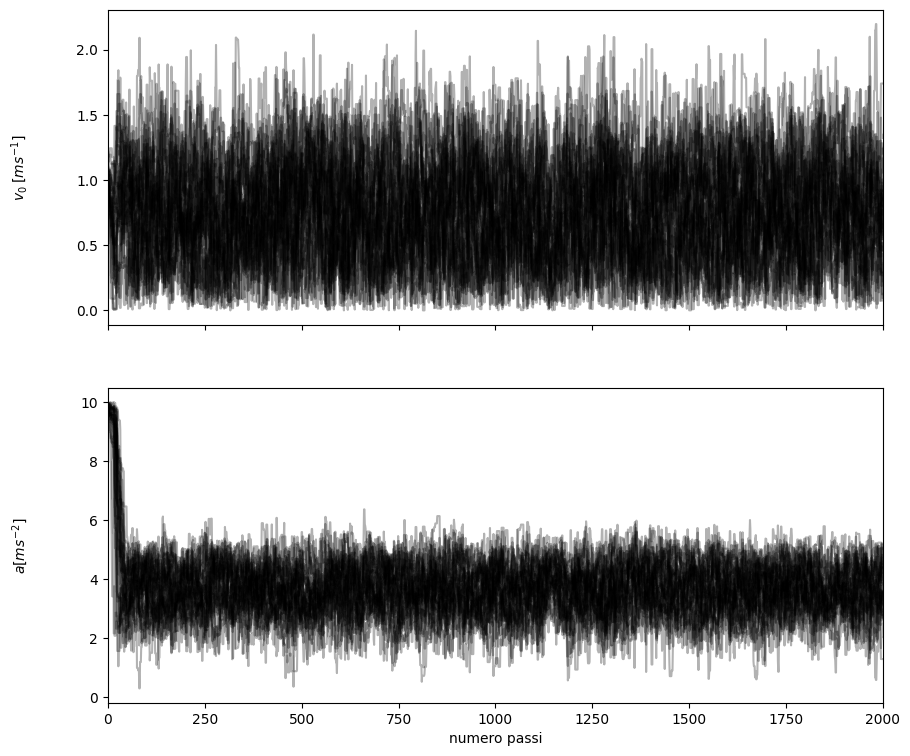

In [180]:
# Grafico campionamenti per i parametri liberi
fig, axes = plt.subplots(ndim_acc, figsize=(10, 9), sharex=True)
samples_acc = sampler_acc.get_chain()

labels = [r'$v_0 \;[m s^{-1}]$', r'$a [m s^{-2}]$' ]
for i in range(ndim_acc):
    ax = axes[i]
    ax.plot(samples_acc[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_acc))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("numero passi");

Notare come dopo unpo' di passi il valore dei paramtri, soprattutto l'accelerazione) si stabilizzi in un intervallo limitato.

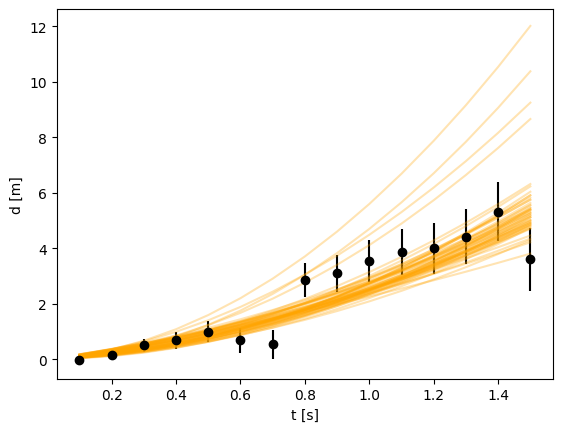

In [181]:
# Grafico dati con alcuni campionamenti dei paramtri
plt.errorbar(time, accdata, yerr=sigmay, fmt="ok", capsize=0)
plt.xlabel('t [s]')
plt.ylabel('d [m]')

# Grafico 50 campionamenti posterior .
samples_acc = sampler_acc.flatchain
for s in samples_acc[np.random.randint(len(samples_acc), size=50)]:
    plt.plot(time, model_acc(s, time), color="orange", alpha=0.3)

E' bene escludere i passi iniziali perchè influenzati dall scelta dei paramtri di partenza e considerare i campionamenti solo dopco che abbaino raggiunto una zona di stabilità.

In alcuni casi si effettua quello che viene  chiamato `burn-in`, ovvero si si fa girare il sampler per un numero limitato di passi e si utilizza la posizione raggiunta come punto di partenza per il campionameno vero e proprio.

In [182]:
# Escludo i primi 200 passi dalla valutazione 
flat_samples_acc = sampler_acc.get_chain(discard=200, thin=15, flat=True)
print(samples_acc.shape)

(64000, 2)


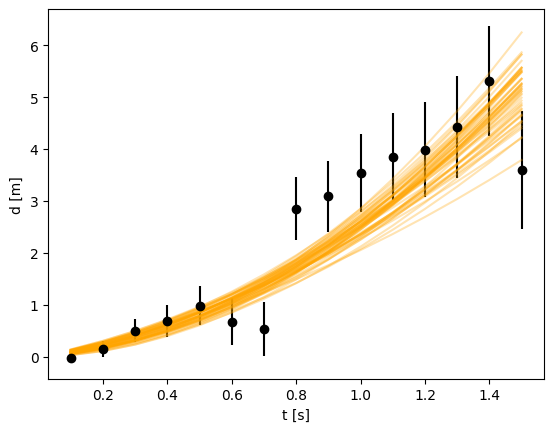

In [183]:
# Grafico dei dati e dei campionamenti escludendo i primi 200 passi
plt.errorbar(time, accdata, yerr=sigmay, fmt="ok", capsize=0)
plt.xlabel('t [s]')
plt.ylabel('d [m]')

# Plot 50 posterior samples.
for s in flat_samples_acc[np.random.randint( len(flat_samples_acc), size=50)]:
    plt.plot(time, model_acc(s, time), color="orange", alpha=0.3)

Il modulo python `corner` permette di visualizzare i risultati attraverso un *corner plot* in cui vengino visualizzate le *posterior distribtion* dei singoli  parametri e della correlazione a coppie. 

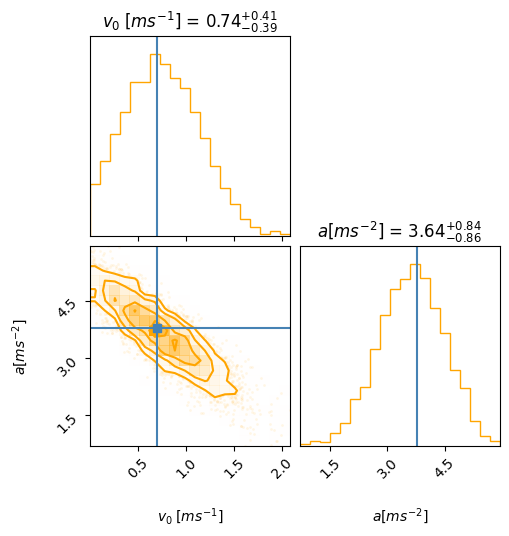

In [184]:
fig = corner.corner( flat_samples_acc, labels=labels, truths=vtruth , show_titles=True, color='orange');

### Effetto della pior distribution

Sfruttando informazioni pregresse si può definire una *prior* non uniforme che aiuti a cstringere il risultato finale (*posterior*).

Ad esempio sospettando che il pianeta in questione sia Marte ma no ricordando esattamente il valore dell'accelerazione possiamo definire la probabilità a priori come una funzione di Gauss cone $\mu = 3.7\; m s^{-2}$ e $\sigma = 0.2 \; m s^{-2}$.

In [185]:
# Prior con probabilità gaussiana per l'accelerazione
# media = 3.7, sigma = 0.2
def lnprior_mars(p):
    v0, g = p
    if 0 < v0 < 10 and  0 < g < 10:
        return stats.norm.pdf(g, loc=3.7, scale=0.2)
    return -np.inf

# logprob con prior per Marte
def lnprob_mars(p, t, y, yerr):
    lp = lnprior_mars(p)
    
    if np.isfinite(lp):
        return lp + lnlike_acc(p, t, y, yerr) 
    
    return -np.inf

In [186]:
# Ridefinisco walker e paramtri di partenza
nw = 32

initial_mars = np.array([1, 3.7])
ndim_mars = len(initial_mars)
p0 = np.array(initial_mars)  +0.1*np.random.randn(nw, ndim_mars)

# definisco nuovo sampler 
sampler_mars = emcee.EnsembleSampler(nw, ndim_mars, lnprob_mars, args=(time, accdata, sigmay))

# lancio 2000 campionamenti
print("Running production...")
sampler_mars.run_mcmc(p0, 2000, progress=True);

Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 430.55it/s]


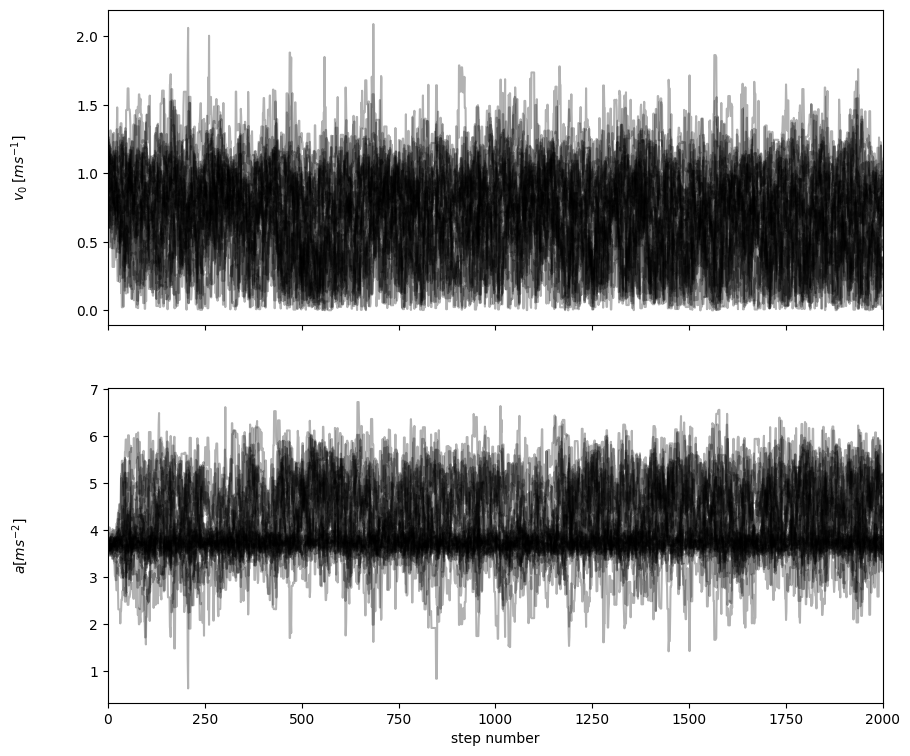

In [187]:
# analisi campionamento parametri
fig, axes = plt.subplots(ndim_mars, figsize=(10, 9), sharex=True)
samples_mars = sampler_mars.get_chain()

for i in range(ndim_mars):
    ax = axes[i]
    ax.plot(samples_mars[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_mars))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(64000, 2)


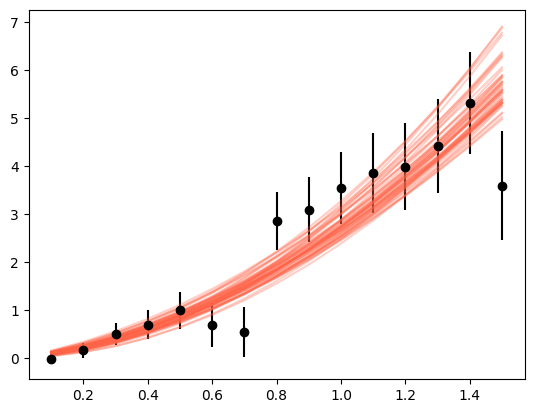

In [188]:
# Grafico dati e aluni campionamti (esclisi i primi 200 passi)
flat_samples_mars = sampler_mars.get_chain(discard=200, thin=15, flat=True)
print(samples_acc.shape)

# Grafico dati 
plt.errorbar(time, accdata, yerr=sigmay, fmt="ok", capsize=0)

# Grafico 50 posterior
for s in flat_samples_mars[np.random.randint( len(flat_samples_mars), size=50)]:
    plt.plot(time, model_acc(s, time), color="tomato", alpha=0.3)

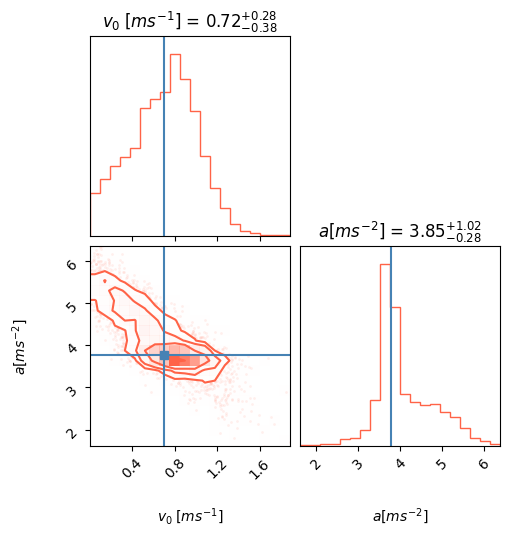

In [189]:
# Corner plot
fig = corner.corner( flat_samples_mars, labels=labels, truths=vtruth , show_titles=True, color='tomato');

Notare come la *posterior* per l'accelerazione sia cambiata diventando più stretta e portando ad una riduzione dell'incertezza.